# Title: Alert Investigation (Windows Process Alerts)

**Notebook Version:** 1.0<br>
**Python Version:** Python 3.6 (including Python 3.6 - AzureML)<br>
**Required Packages**: kqlmagic, msticpy, pandas, numpy, matplotlib, networkx, ipywidgets, ipython, scikit_learn<br>
**Platforms Supported**:<br>
- Azure Notebooks Free Compute
- Azure Notebooks DSVM
- OS Independent

**Data Sources Required**:<br>
- Log Analytics - SecurityAlert, SecurityEvent (EventIDs 4688 and 4624/25)
- (Optional) - VirusTotal (with API key)

## Description:
This notebook is intended for triage and investigation of security alerts. It is specifically targeted at alerts triggered by suspicious process activity on Windows hosts. Some of the sections will work on other types of alerts but this is not guaranteed.


<a id='toc'></a>
## Table of Contents
- [Setup and Authenticate](#setup)

- [Get Alerts List](#getalertslist)
- [Choose an Alert to investigate](#enteralertid)
  - [Extract Properties and entities from alert](#extractalertproperties)
  - [Entity Graph](#entitygraph)
- [Related Alerts](#related_alerts)
- [Session Process Tree](#processtree)
  - [Process Timeline](#processtimeline)
- [Other Process on Host](#process_clustering)
- [Check for IOCs in Commandline](#cmdlineiocs)
  - [VirusTotal lookup](#virustotallookup)
- [Alert command line - Occurrence on other hosts in subscription](#cmdlineonotherhosts)
- [Host Logons](#host_logons)
  - [Alert Account](#logonaccount)
  - [Failed Logons](#failed_logons)
- [Appendices](#appendices)
  - [Saving data to Excel](#appendices)


<a id='setup'></a>[Contents](#toc)
# Setup

1. Make sure that you have installed packages specified in the setup (uncomment the lines to execute)
2. There are some manual steps up to selecting the alert ID. After this most of the notebook can be executed sequentially
3. Major sections should be executable independently (e.g. Alert Command line and Host Logons can be run skipping Session Process Tree)

## Install Packages
The first time this cell runs for a new Azure Notebooks project or local Python environment it will take several minutes to download and install the packages. In subsequent runs it should run quickly and confirm that package dependencies are already installed. Unless you want to upgrade the packages you can feel free to skip execution of the next cell.

If you see any import failures (```ImportError```) in the notebook, please re-run this cell and answer 'y', then re-run the cell where the failure occurred. 

Note you may see some warnings about package incompatibility with certain packages. This does not affect the functionality of this notebook but you may need to upgrade the packages producing the warnings to a more recent version.

In [ ]:
import sys
import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)

MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)
    
# Package Installs - try to avoid if they are already installed
try:
    import msticpy.sectools as sectools
    import Kqlmagic
    print('If you answer "n" this cell will exit with an error in order to avoid the pip install calls,')
    print('This error can safely be ignored.')
    resp = input('msticpy and Kqlmagic packages are already loaded. Do you want to re-install? (y/n)')
    if resp.strip().lower() != 'y':
        sys.exit('pip install aborted - you may skip this error and continue.')
    else:
        print('After installation has completed, restart the current kernel and run '
              'the notebook again skipping this cell.')
except ImportError:
    pass

print('\nPlease wait. Installing required packages. This may take a few minutes...')
!pip install git+https://github.com/microsoft/msticpy --upgrade --user
!pip install Kqlmagic --no-cache-dir --upgrade --user

print('\nTo ensure that the latest versions of the installed libraries '
      'are used, please restart the current kernel and run '
      'the notebook again skipping this cell.')

### Import Python Packages

### Get WorkspaceId
To find your Workspace Id go to [Log Analytics](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.

In [24]:
# Imports
import sys
MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

import numpy as np
from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
sns.set()
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
 
import msticpy.sectools as sectools
import msticpy.nbtools as mas
import msticpy.nbtools.kql as qry
import msticpy.nbtools.nbdisplay as nbdisp

# Some of our dependencies (networkx) still use deprecated Matplotlib
# APIs - we can't do anything about it so suppress them from view
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)


In [30]:
import os
from msticpy.nbtools.wsconfig import WorkspaceConfig
ws_config_file = 'config.json'

WORKSPACE_ID = None
TENANT_ID = None
try:
    ws_config = WorkspaceConfig(ws_config_file)
    display(Markdown(f'Read Workspace configuration from local config.json for workspace **{ws_config["workspace_name"]}**'))
    for cf_item in ['tenant_id', 'subscription_id', 'resource_group', 'workspace_id', 'workspace_name']:
        display(Markdown(f'**{cf_item.upper()}**: {ws_config[cf_item]}'))
                     
    if ('cookiecutter' not in ws_config['workspace_id'] or
            'cookiecutter' not in ws_config['tenant_id']):
        WORKSPACE_ID = ws_config['workspace_id']
        TENANT_ID = ws_config['tenant_id']
except:
    pass

if not WORKSPACE_ID or not TENANT_ID:
    display(Markdown('**Workspace configuration not found.**\n\n'
                     'Please go to your Log Analytics workspace, copy the workspace ID'
                     ' and/or tenant Id and paste here.<br> '
                     'Or read the workspace_id from the config.json in your Azure Notebooks project.'))
    ws_config = None
    ws_id = mas.GetEnvironmentKey(env_var='WORKSPACE_ID',
                              prompt='Please enter your Log Analytics Workspace Id:', auto_display=True)
    ten_id = mas.GetEnvironmentKey(env_var='TENANT_ID',
                              prompt='Please enter your Log Analytics Tenant Id:', auto_display=True)

    

Read Workspace configuration from local config.json for workspace **ASIHuntOMSWorkspaceV4**

**TENANT_ID**: 72f988bf-86f1-41af-91ab-2d7cd011db47

**SUBSCRIPTION_ID**: 40dcc8bf-0478-4f3b-b275-ed0a94f2c013

**RESOURCE_GROUP**: ASIHuntOMSWorkspaceRG

**WORKSPACE_ID**: 52b1ab41-869e-4138-9e40-2a4457f09bf0

**WORKSPACE_NAME**: ASIHuntOMSWorkspaceV4

### Authenticate to Log Analytics
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

Note: you may occasionally see a JavaScript error displayed at the end of the authentication - you can safely ignore this.<br>
On successful authentication you should see a ```popup schema``` button.

In [29]:
if not WORKSPACE_ID or not TENANT_ID:
    try:
        WORKSPACE_ID = ws_id.value
        TENANT_ID = ten_id.value
    except NameError:
        raise ValueError('No workspace or Tenant Id.')

mas.kql.load_kql_magic()
%kql loganalytics://code().tenant(TENANT_ID).workspace(WORKSPACE_ID)

<a id='getalertslist'></a>[Contents](#toc)
# Get Alerts List

Specify a time range to search for alerts. One this is set run the following cell to retrieve any alerts in that time window.
You can change the time range and re-run the queries until you find the alerts that you want.

In [31]:
alert_q_times = mas.QueryTime(units='day', max_before=20, before=5, max_after=1)
alert_q_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [32]:
alert_counts = qry.list_alerts_counts(provs=[alert_q_times])
alert_list = qry.list_alerts(provs=[alert_q_times])
print(len(alert_counts), ' distinct alert types')
print(len(alert_list), ' distinct alerts')
display(HTML('<h2>Alert Timeline</h2>'))
nbdisp.display_timeline(data=alert_list, source_columns = ['AlertName', 'CompromisedEntity'], title='Alerts', height=200)
display(HTML('<h2>Top alerts</h2>'))
alert_counts.head(20) # remove '.head(20)'' to see the full list grouped by AlertName

12  distinct alert types
51  distinct alerts


Loading BokehJS ...

,AlertName,alertCount,firstAlert,lastAlert
0,SSH Anomalous Login ML,31,2019-02-16 21:30:06,2019-02-19 17:29:26
1,Detected suspicious file download,7,2019-02-15 03:51:09,2019-02-25 15:34:23
2,Suspicious Activity Detected,2,2019-02-15 20:27:38,2019-02-25 20:52:36
3,Possible suspicious scheduling tasks access detected,2,2019-02-13 02:59:15,2019-02-15 04:03:30
4,Security incident detected,2,2019-02-14 18:03:23,2019-02-15 10:14:37
5,Suspicious system process executed,1,2019-02-14 11:52:06,2019-02-14 11:52:06
6,Potential attempt to bypass AppLocker detected,1,2019-02-14 11:52:06,2019-02-14 11:52:06
7,Security incident with shared process detected,1,2019-02-14 05:19:13,2019-02-14 05:19:13
8,Suspiciously named process detected,1,2019-02-13 22:04:16,2019-02-13 22:04:16
9,Digital currency mining related behavior detected,1,2019-02-13 22:04:15,2019-02-13 22:04:15


<a id='enteralertid'></a>[Contents](#toc)
# Choose Alert to Investigate
Either pick an alert from a list of retrieved alerts or paste the SystemAlertId into the text box in the following section.

### Select alert from list
As you select an alert, the main properties will be shown below the list.

Use the filter box to narrow down your search to any substring in the AlertName.

In [33]:
alert_select = mas.AlertSelector(alerts=alert_list, action=nbdisp.display_alert)
alert_select.display()

### Or paste in an alert ID and fetch it
**Skip this if you selected from the above list**

In [34]:
# Allow alert to be selected
# Allow subscription to be selected
get_alert = mas.GetSingleAlert(action=nbdisp.display_alert)
get_alert.display()

<a id='extractalertproperties'></a>[Contents](#toc)
## Extract properties and entities from Alert
This section extracts the alert information and entities into a SecurityAlert object allowing us to query the properties more reliably. 

In particular, we use the alert to automatically provide parameters for queries and UI elements.
Subsequent queries will use properties like the host name and derived properties such as the OS family (Linux or Windows) to adapt the query. Query time selectors like the one above will also default to an origin time that matches the alert selected.

The alert view below shows all of the main properties of the alert plus the extended property dictionary (if any) and JSON representations of the Entity.

In [35]:
# Extract entities and properties into a SecurityAlert class
if alert_select.selected_alert is None and get_alert.selected_alert is None:
    sys.exit("Please select an alert before executing remaining cells.")

if get_alert.selected_alert is not None:
    security_alert = mas.SecurityAlert(get_alert.selected_alert)
elif alert_select.selected_alert is not None:
    security_alert = mas.SecurityAlert(alert_select.selected_alert)
    
mas.disp.display_alert(security_alert, show_entities=True)

,43
TenantId,52b1ab41-869e-4138-9e40-2a4457f09bf0
StartTimeUtc,2019-02-13 22:03:42
EndTimeUtc,2019-02-13 22:03:42
ProviderAlertId,649075c9-dc5d-4a75-a848-9c51f70a45ae
SystemAlertId,2518522053771835343_649075c9-dc5d-4a75-a848-9c51f70a45ae
ProviderName,Detection
VendorName,Microsoft
AlertType,Suspiciously named process detected
AlertName,Suspiciously named process detected
AlertDisplayName,Suspiciously named process detected


{ 'AzureID': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/ASIHuntOMSWorkspaceRG/providers/Microsoft.Compute/virtualMachines/MSTICAlertsWin1',
  'HostName': 'msticalertswin1',
  'OMSAgentID': '263a788b-6526-4cdc-8ed9-d79402fe4aa0',
  'Type': 'host'}
{ 'Host': { 'AzureID': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/ASIHuntOMSWorkspaceRG/providers/Microsoft.Compute/virtualMachines/MSTICAlertsWin1',
            'HostName': 'msticalertswin1',
            'OMSAgentID': '263a788b-6526-4cdc-8ed9-d79402fe4aa0',
            'Type': 'host'},
  'NTDomain': 'msticalertswin1',
  'Name': 'msticadmin',
  'Type': 'account'}
{ 'Account': { 'Host': { 'AzureID': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/ASIHuntOMSWorkspaceRG/providers/Microsoft.Compute/virtualMachines/MSTICAlertsWin1',
                         'HostName': 'msticalertswin1',
                         'OMSAgentID': '263a788b-6526-4cdc-8ed9-d79402fe4aa0',
              

<a id='entitygraph'></a>[Contents](#toc)
## Entity Graph
Depending on the type of alert there may be one or more entities attached as properties. Entities are things like Host, Account, IpAddress, Process, etc. - essentially the 'nouns' of security investigation. Events and alerts are the things that link them in actions so can be thought of as the verbs. Entities are often related to other entities - for example a process will usually have a related file entity (the process image) and an Account entity (the context in which the process was running). Endpoint alerts typically always have a host entity (which could be a physical or virtual machine).

### Plot using Networkx/Matplotlib

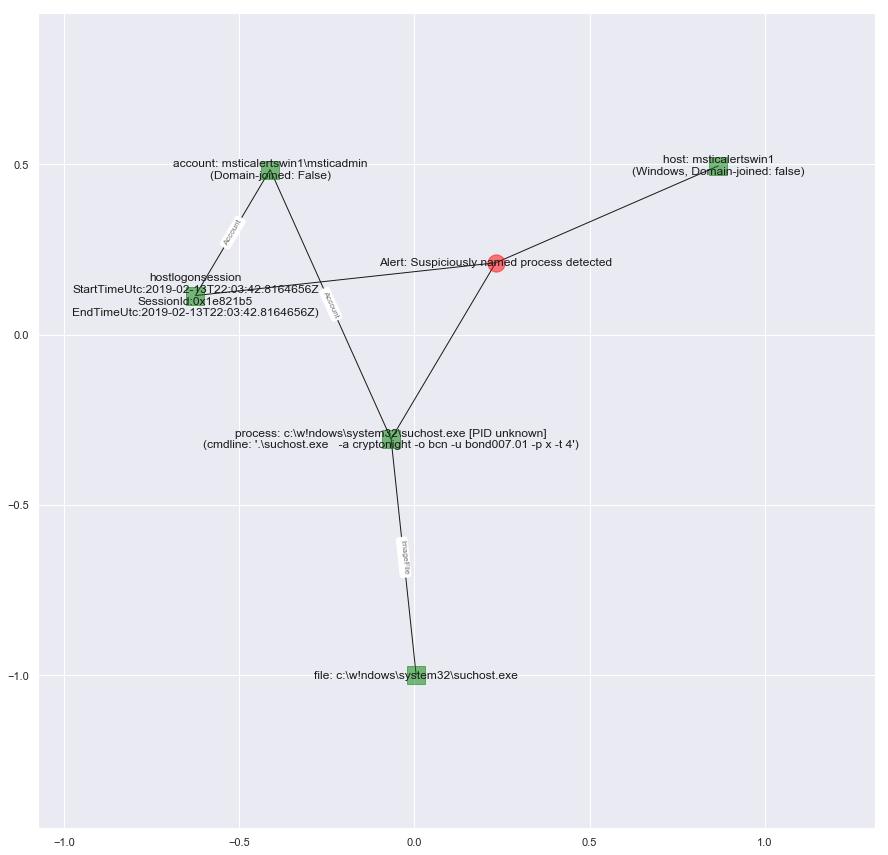

In [36]:
# Draw the graph using Networkx/Matplotlib
%matplotlib inline
alertentity_graph = mas.create_alert_graph(security_alert)
nbdisp.draw_alert_entity_graph(alertentity_graph, width=15)

<a id='related_alerts'></a>[Contents](#toc)
# Related Alerts
For a subset of entities in the alert we can search for any alerts that have that entity in common. Currently this query looks for alerts that share the same Host, Account or Process and lists them below. 
**Notes:**
- Some alert types do not include all of these entity types.
- The original alert will be included in the "Related Alerts" set if it occurs within the query time boundary set below.

The query time boundaries default to a longer period than when searching for the alert. You can extend the time boundary searched before or after the alert time. If the widget doesn't support the time boundary that you want you can change the max_before and max_after parameters in the call to QueryTime below to extend the possible time boundaries.

In [38]:
# set the origin time to the time of our alert
query_times = mas.QueryTime(units='day', origin_time=security_alert.TimeGenerated, 
                            max_before=28, max_after=1, before=5)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [40]:
related_alerts = qry.list_related_alerts(provs=[query_times, security_alert])

if related_alerts is not None and not related_alerts.empty:
    host_alert_items = related_alerts\
        .query('host_match == @True')[['AlertType', 'StartTimeUtc']]\
        .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
    acct_alert_items = related_alerts\
        .query('acct_match == @True')[['AlertType', 'StartTimeUtc']]\
        .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
    proc_alert_items = related_alerts\
        .query('proc_match == @True')[['AlertType', 'StartTimeUtc']]\
        .groupby('AlertType').StartTimeUtc.agg('count').to_dict()

    def print_related_alerts(alertDict, entityType, entityName):
        if len(alertDict) > 0:
            print('Found {} different alert types related to this {} (\'{}\')'
                  .format(len(alertDict), entityType, entityName))
            for (k,v) in alertDict.items():
                print('    {}, Count of alerts: {}'.format(k, v))
        else:
            print('No alerts for {} entity \'{}\''.format(entityType, entityName))

    print_related_alerts(host_alert_items, 'host', security_alert.hostname)
    print_related_alerts(acct_alert_items, 'account', 
                         security_alert.primary_account.qualified_name 
                         if security_alert.primary_account
                         else None)
    print_related_alerts(proc_alert_items, 'process', 
                         security_alert.primary_process.ProcessFilePath 
                         if security_alert.primary_process
                         else None)
    nbdisp.display_timeline(data=related_alerts, source_columns = ['AlertName'], title='Alerts', height=100)
else:
    display(Markdown('No related alerts found.'))

Found 8 different alert types related to this host ('msticalertswin1')
    Detected potentially suspicious use of Telegram tool, Count of alerts: 2
    Detected the disabling of critical services, Count of alerts: 2
    Digital currency mining related behavior detected, Count of alerts: 2
    Potential attempt to bypass AppLocker detected, Count of alerts: 4
    Security incident detected, Count of alerts: 2
    Security incident with shared process detected, Count of alerts: 3
    Suspicious system process executed, Count of alerts: 2
    Suspiciously named process detected, Count of alerts: 2
Found 13 different alert types related to this account ('msticalertswin1\msticadmin')
    An history file has been cleared, Count of alerts: 12
    Azure Security Center test alert (not a threat), Count of alerts: 13
    Detected potentially suspicious use of Telegram tool, Count of alerts: 2
    Detected the disabling of critical services, Count of alerts: 2
    Digital currency mining related 

Loading BokehJS ...

### Show these related alerts on a graph
This should indicate which entities the other alerts are related to.

This can be unreadable with a lot of alerts. Use the matplotlib interactive zoom control to zoom in to part of the graph.

In [ ]:
# Draw a graph of this (add to entity graph)
%matplotlib notebook
%matplotlib inline

if related_alerts is not None and not related_alerts.empty:
    rel_alert_graph = mas.add_related_alerts(related_alerts=related_alerts,
                                             alertgraph=alertentity_graph)
    nbdisp.draw_alert_entity_graph(rel_alert_graph, width=15)
else:
    display(Markdown('No related alerts found.'))

### Browse List of Related Alerts
Select an Alert to view details. 

If you want to investigate that alert - copy its *SystemAlertId* property and open a new instance of this notebook to investigate this alert.

In [41]:

def disp_full_alert(alert):
    global related_alert
    related_alert = mas.SecurityAlert(alert)
    nbdisp.display_alert(related_alert, show_entities=True)

if related_alerts is not None and not related_alerts.empty:
    related_alerts['CompromisedEntity'] = related_alerts['Computer']
    print('Selected alert is available as \'related_alert\' variable.')
    rel_alert_select = mas.AlertSelector(alerts=related_alerts, action=disp_full_alert)
    rel_alert_select.display()
else:
    display(Markdown('No related alerts found.'))

Selected alert is available as 'related_alert' variable.


<a id='processtree'></a>[Contents](#toc)
# Get Process Tree
If the alert has a process entity this section tries to retrieve the entire process tree to which that process belongs.

Notes:
- The alert must have a process entity
- Only processes started within the query time boundary will be included
- Ancestor and descented processes are retrieved to two levels (i.e. the parent and grandparent of the alert process plus any child and grandchild processes).
- Sibling processes are the processes that share the same parent as the alert process
- This can be a long-running query, especially if a wide time window is used! Caveat Emptor!

The source (alert) process is shown in red.

What's shown for each process:
- Each process line is indented according to its position in the tree hierarchy
- Top line fields:
  - \[relationship to source process:lev# - where # is the hops away from the source process\]
  - Process creation date-time (UTC)
  - Process Image path
  - PID - Process Id
  - SubjSess - the session Id of the process spawning the new process
  - TargSess - the new session Id if the process is launched in another context/session. If 0/0x0 then the process is launched in the same session as its parent
- Second line fields:
  - Process command line
  - Account - name of the account context in which the process is running

In [42]:
# set the origin time to the time of our alert
query_times = mas.QueryTime(units='minute', origin_time=security_alert.origin_time)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [63]:
from msticpy.nbtools.query_defns import DataFamily

if security_alert.data_family != DataFamily.WindowsSecurity:
    raise ValueError('The remainder of this notebook currently only supports Windows. '
                     'Linux support is in development but not yet implemented.')

def extract_missing_pid(security_alert):
    for pid_ext_name in ['Process Id', 'Suspicious Process Id']:
        pid = security_alert.ExtendedProperties.get(pid_ext_name, None)
        if pid:
            return pid

def extract_missing_sess_id(security_alert):
    sess_id = security_alert.ExtendedProperties.get('Account Session Id', None)
    if sess_id:
        return sess_id
    for session in [e for e in security_alert.entities if
                    e['Type'] == 'host-logon-session' or e['Type'] == 'hostlogonsession']:
        return session['SessionId']
            
if (security_alert.primary_process):
    # Do some patching up if the process entity doesn't have a PID
    pid = security_alert.primary_process.ProcessId
    if not pid:
        pid = extract_missing_pid(security_alert)
        if pid:
            security_alert.primary_process.ProcessId = pid
        else:
            raise ValueError('Could not find the process Id for the alert process.')
    
    # Do the same if we can't find the account logon ID
    if not security_alert.get_logon_id():
        sess_id = extract_missing_sess_id(security_alert)
        if sess_id and security_alert.primary_account:
            security_alert.primary_account.LogonId = sess_id
        else:
            raise ValueError('Could not find the session Id for the alert process.')
    
    # run the query
    process_tree = qry.get_process_tree(provs=[query_times, security_alert])

    if len(process_tree) > 0:
        # Print out the text view of the process tree
        nbdisp.display_process_tree(process_tree)
    else:
        display(Markdown('No processes were returned so cannot obtain a process tree.'
                     '\n\nSkip to [Other Processes](#process_clustering) later in the'
                     ' notebook to retrieve all processes'))
else:
    display(Markdown('This alert has no process entity so cannot obtain a process tree.'
                     '\n\nSkip to [Other Processes](#process_clustering) later in the'
                     ' notebook to retrieve all processes'))
    process_tree = None


<a id='processtimeline'></a>[Contents](#toc)
## Process TimeLine
This shows each process in the process tree on a timeline view.

Labelling of individual process is very performance intensive and often results in nothing being displayed at all! Besides, for large numbers of processes it would likely result in an unreadable mess. 

Your main tools for negotiating the timeline are the Hover tool (toggled on and off by the speech bubble icon) and the wheel-zoom and pan tools (the former is an icon with an elipse and a magnifying glass, the latter is the crossed-arrows icon). The wheel zoom is particularly useful.

As you hover over each process it will display the image name, PID and commandline.

Also shown on the graphic is the timestamp line of the source/alert process.

In [65]:
# Show timeline of events
if process_tree is not None and not process_tree.empty:
    nbdisp.display_timeline(data=process_tree, alert=security_alert, 
                            title='Alert Process Session', height=250)

Loading BokehJS ...

Alert start time =  2019-02-13 22:03:42


<a id='process_clustering'></a>[Contents](#toc)
# Other Processes on Host - Clustering
Sometimes you don't have a source process to work with. Other times it's just useful to see what else is going on on the host. This section retrieves all processes on the host within the time bounds
set in the query times widget.

You can display the raw output of this by looking at the *processes_on_host* dataframe. Just copy this into a new cell and hit Ctrl-Enter.

Usually though, the results return a lot of very repetitive and unintersting system processes so we attempt to cluster these to make the view easier to negotiate. 
To do this we process the raw event list output to extract a few features that render strings (such as commandline)into numerical values. The default below uses the following features:
- commandLineTokensFull - this is a count of common delimiters in the commandline 
  (given by this regex r'[\s\-\\/\.,"\'|&:;%$()]'). The aim of this is to capture the commandline structure while ignoring variations on what is essentially the same pattern (e.g. temporary path GUIDs, target IP or host names, etc.)
- pathScore - this sums the ordinal (character) value of each character in the path (so /bin/bash and /bin/bosh would have similar scores).
- isSystemSession - 1 if this is a root/system session, 0 if anything else.

Then we run a clustering algorithm (DBScan in this case) on the process list. The result groups similar (noisy) processes together and leaves unique process patterns as single-member clusters.

### Clustered Processes (i.e. processes that have a cluster size > 1)

Number of input events: 190
Number of clustered events: 24


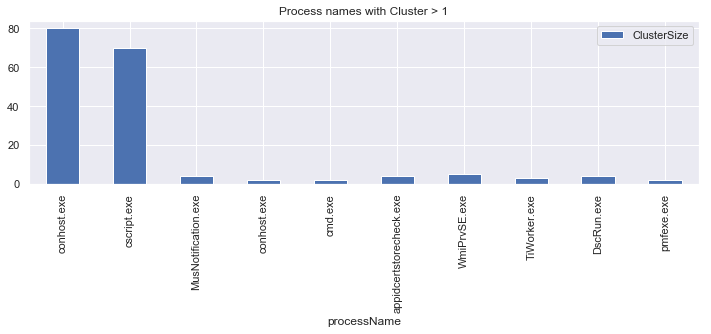

In [67]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features

processes_on_host = qry.list_processes(provs=[query_times, security_alert])

if processes_on_host is not None and not processes_on_host.empty:
    feature_procs = add_process_features(input_frame=processes_on_host,
                                         path_separator=security_alert.path_separator)

    # you might need to play around with the max_cluster_distance parameter.
    # decreasing this gives more clusters.
    (clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs,
                                                        cluster_columns=['commandlineTokensFull', 
                                                                         'pathScore', 
                                                                         'isSystemSession'],
                                                        max_cluster_distance=0.0001)
    print('Number of input events:', len(feature_procs))
    print('Number of clustered events:', len(clus_events))
    clus_events[['ClusterSize', 'processName']][clus_events['ClusterSize'] > 1].plot.bar(x='processName', 
                                                                                         title='Process names with Cluster > 1', 
                                                                                         figsize=(12,3));
else:
    display(Markdown('Unable to obtain any processes for this host. This feature'
                     ' is currently only supported for Windows hosts.'
                     '\n\nIf this is a Windows host skip to [Host Logons](#host_logons)'
                     ' later in the notebook to examine logon events.'))

### Variability in Command Lines and Process Names
The top chart shows the variability of command line content for a give process name. The wider the box, the more instances were found with different command line structure 

Note, the 'structure' in this case is measured by the number of tokens or delimiters in the command line and does not look at content differences. This is done so that commonly varying instances of the same command line are grouped together.<br>
For example `updatepatch host1.mydom.com` and `updatepatch host2.mydom.com` will be grouped together.

The second chart shows the variability in executable path. This does compare content so `c:\windows\system32\net.exe` and `e:\windows\system32\net.exe` are treated as distinct. You would normally not expect to see any variability in this chart unless you have multiple copies of the same name executable or an executable is trying masquerade as another well-known binary.

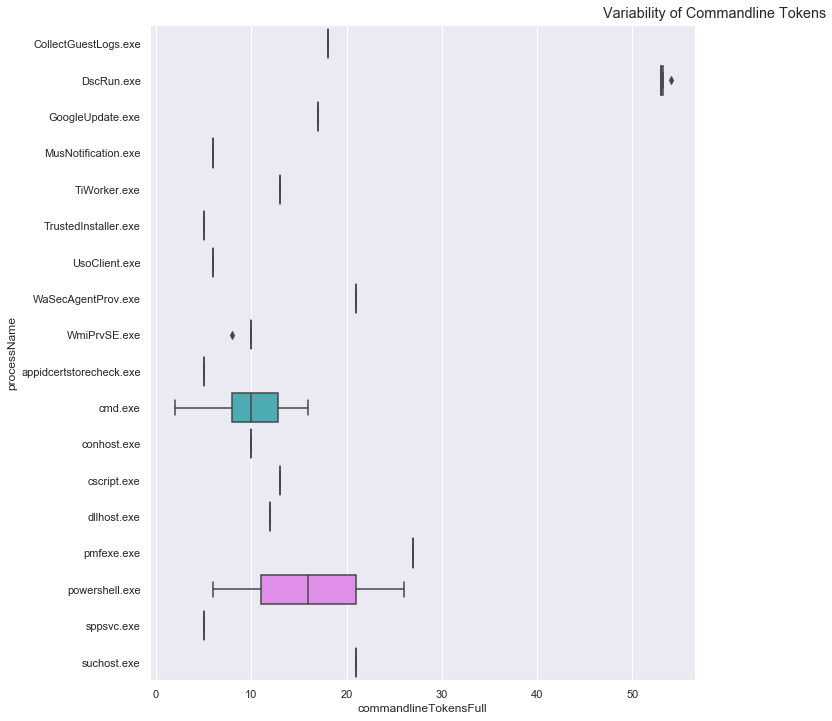

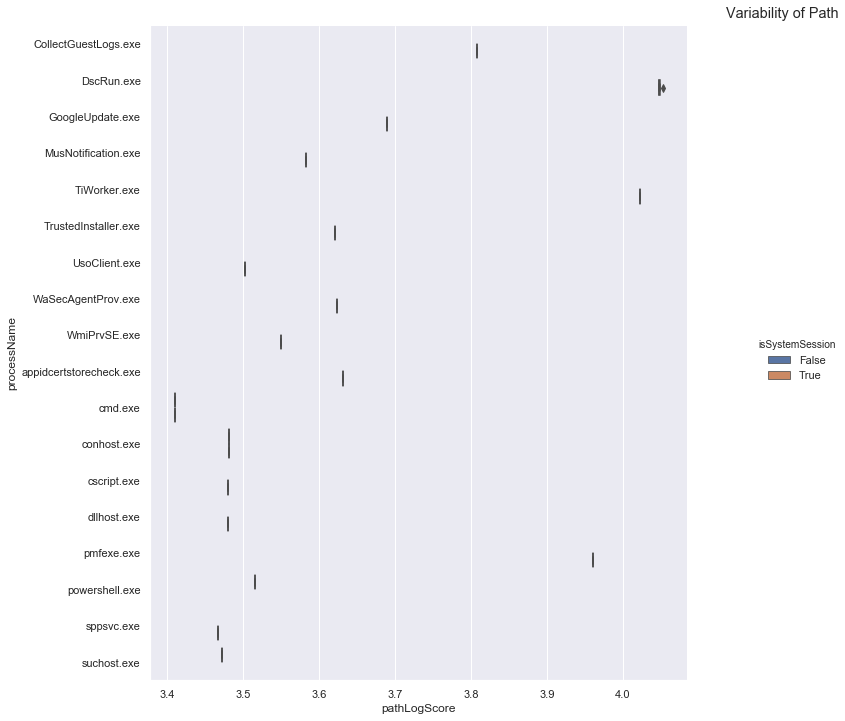

In [69]:
# Looking at the variability of commandlines and process image paths
import seaborn as sns
sns.set(style="darkgrid")

if processes_on_host is not None and not processes_on_host.empty:
    proc_plot = sns.catplot(y="processName", x="commandlineTokensFull", 
                            data=feature_procs.sort_values('processName'),
                            kind='box', height=10)
    proc_plot.fig.suptitle('Variability of Commandline Tokens', x=1, y=1)

    proc_plot = sns.catplot(y="processName", x="pathLogScore", 
                            data=feature_procs.sort_values('processName'),
                            kind='box', height=10, hue='isSystemSession')
    proc_plot.fig.suptitle('Variability of Path', x=1, y=1);

The top graph shows that, for a given process, some have a wide variability in their command line content while the majority have little or none. Looking at a couple of examples - like cmd.exe, powershell.exe, reg.exe, net.exe - we can recognize several common command line tools.

The second graph shows processes by full process path content. We wouldn't normally expect to see variation here - as is the cast with most. There is also quite a lot of variance in the score making it a useful proxy feature for unique path name (this means that proc1.exe and proc2.exe that have the same commandline score won't get collapsed into the same cluster).

Any process with a spread of values here means that we are seeing the same process name (but not necessarily the same file) is being run from different locations.

In [70]:
if not clus_events.empty:
    resp = input('View the clustered data? y/n')
    if resp == 'y':
        display(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                                          'NewProcessName', 'CommandLine', 
                                                          'ClusterSize', 'commandlineTokensFull',
                                                          'pathScore', 'isSystemSession']])

View the clustered data? y/ny


,TimeGenerated,LastEventTime,NewProcessName,CommandLine,ClusterSize,commandlineTokensFull,pathScore,isSystemSession
51,2019-02-13 21:09:43.893,2019-02-13 21:35:26.417,C:\Windows\System32\appidcertstorecheck.exe,C:\Windows\system32\appidcertstorecheck.exe,4.0,5,4285,True
57,2019-02-13 21:10:57.437,2019-02-13 21:27:02.473,C:\Windows\System32\UsoClient.exe,C:\Windows\system32\usoclient.exe StartScan,1.0,6,3180,True
60,2019-02-13 21:10:58.257,2019-02-13 21:26:53.250,C:\Windows\System32\wbem\WmiPrvSE.exe,C:\Windows\system32\wbem\wmiprvse.exe -secured -Embedding,5.0,10,3546,True
62,2019-02-13 21:10:58.567,2019-02-13 21:35:26.443,C:\Windows\WinSxS\amd64_microsoft-windows-servicingstack_31bf3856ad364e35_10.0.14393.2602_none_7...,C:\Windows\winsxs\amd64_microsoft-windows-servicingstack_31bf3856ad364e35_10.0.14393.2602_none_7...,3.0,13,10527,True
159,2019-02-13 21:27:01.893,2019-02-13 21:27:02.473,C:\Windows\System32\sppsvc.exe,C:\Windows\system32\sppsvc.exe,1.0,5,2933,True
160,2019-02-13 21:27:02.473,2019-02-13 21:27:02.473,C:\Windows\System32\wbem\WmiPrvSE.exe,C:\Windows\system32\wbem\wmiprvse.exe -Embedding,1.0,8,3546,True
135,2019-02-13 21:28:01.787,2019-02-13 21:27:02.473,C:\Program Files (x86)\Google\Update\GoogleUpdate.exe,"""C:\Program Files (x86)\Google\Update\GoogleUpdate.exe"" /ua /installsource scheduler",1.0,17,4895,True
14,2019-02-13 21:41:16.580,2019-02-13 21:08:46.143,C:\Windows\System32\MusNotification.exe,C:\Windows\system32\MusNotification.exe Display,4.0,6,3826,True
110,2019-02-13 21:48:20.483,2019-02-13 21:27:02.473,C:\WindowsAzure\GuestAgent_2.7.41491.901_2019-01-14_202614\CollectGuestLogs.exe,"""CollectGuestLogs.exe"" -Mode:ga -FileName:C:\WindowsAzure\CollectGuestLogsTemp\7a9d40f2-490e-446...",1.0,18,6421,True
0,2019-02-13 21:49:41.233,2019-02-13 21:27:02.473,C:\Windows\System32\cmd.exe,"""cmd""",1.0,2,2570,True


In [71]:
# Look at clusters for individual process names
def view_cluster(exe_name):
    display(clus_events[['ClusterSize', 'processName', 'CommandLine', 'ClusterId']][clus_events['processName'] == exe_name])
    
display(Markdown('You can view the cluster members for individual processes'
                 'by inserting a new cell and entering:<br>'
                 '`>>> view_cluster(process_name)`<br></div>'
                 'where process_name is the unqualified process binary. E.g<br>'
                 '`>>> view_cluster(\'reg.exe\')`'))

You can view the cluster members for individual processesby inserting a new cell and entering:<br>`>>> view_cluster(process_name)`<br></div>where process_name is the unqualified process binary. E.g<br>`>>> view_cluster('reg.exe')`

### Time showing clustered vs. original data

In [72]:
# Show timeline of events - clustered events
if not clus_events.empty:
    nbdisp.display_timeline(data=clus_events, 
                            overlay_data=processes_on_host, 
                            alert=security_alert, 
                            title='Distinct Host Processes (top) and All Proceses (bottom)')

Loading BokehJS ...

Alert start time =  2019-02-13 22:03:42


<a id='cmdlineiocs'></a>[Contents](#toc)
# Base64 Decode and Check for IOCs
This section looks for Indicators of Compromise (IoC) within the data sets passed to it.

The first section looks at the commandline for the alert process (if any). It also looks for base64 encoded strings within the data - this is a common way of hiding attacker intent. It attempts to decode any strings that look like base64. Additionally, if the base64 decode operation returns any items that look like a base64 encoded string or file, a gzipped binary sequence, a zipped or tar archive, it will attempt to extract the contents before searching for potentially interesting items.

In [73]:
process = security_alert.primary_process
ioc_extractor = sectools.IoCExtract()

if process:
    # if nothing is decoded this just returns the input string unchanged
    base64_dec_str, _ = sectools.b64.unpack_items(input_string=process["CommandLine"])
    if base64_dec_str and '<decoded' in base64_dec_str:
        print('Base64 encoded items found.')
        print(base64_dec_str)
        
    # any IoCs in the string?
    iocs_found = ioc_extractor.extract(base64_dec_str)
    
    if iocs_found:
        print('\nPotential IoCs found in alert process:')
        display(iocs_found)
else:
    print('Nothing to process')



Potential IoCs found in alert process:


defaultdict(set, {'windows_path': {'.\\suchost.exe'}})

### If we have a process tree, look for IoCs in the whole data set
You can replace the data=process_tree parameter to ioc_extractor.extract() to pass other data frames.
use the columns parameter to specify which column or columns that you want to search.

In [76]:
ioc_extractor = sectools.IoCExtract()

try:
    if not process_tree.empty:
        source_processes = process_tree
    else:
        source_processes = clus_events
except NameError:
    source_processes = None
if source_processes is not None: 

    ioc_df = ioc_extractor.extract(data=source_processes, 
                                   columns=['CommandLine'], 
                                   os_family=security_alert.os_family,
                                   ioc_types=['ipv4', 'ipv6', 'dns', 'url',
                                              'md5_hash', 'sha1_hash', 'sha256_hash'])
    if len(ioc_df):
        display(HTML("<h3>IoC patterns found in process tree.</h3>"))
        display(ioc_df)
else:
    ioc_df = None

,IoCType,Observable,SourceIndex
0,url,"http://wh401k.org/getps""",4
1,dns,wh401k.org,4


### If any Base64 encoded strings, decode and search for IoCs in the results.
For simple strings the Base64 decoded output is straightforward. However for nested encodings this can get a little complex and difficult to represent in a tabular format.

**Columns**
 - reference - The index of the row item in dotted notation in depth.seq pairs (e.g. 1.2.2.3 would be the 3 item at depth 3 that is a child of the 2nd item found at depth 1). This may not always be an accurate notation - it is mainly use to allow you to associate an individual row with the reference value contained in the full_decoded_string column of the topmost item).
 - original_string - the original string before decoding.
 - file_name - filename, if any (only if this is an item in zip or tar file).
 - file_type - a guess at the file type (this is currently elementary and only includes a few file types).
 - input_bytes - the decoded bytes as a Python bytes string.
 - decoded_string - the decoded string if it can be decoded as a UTF-8 or UTF-16 string. Note: binary sequences may often successfully decode as UTF-16 strings but, in these cases, the decodings are meaningless.
 - encoding_type - encoding type (UTF-8 or UTF-16) if a decoding was possible, otherwise 'binary'.
 - file_hashes - collection of file hashes for any decoded item.
 - md5 - md5 hash as a separate column.
 - sha1 - sha1 hash as a separate column.
 - sha256 - sha256 hash as a separate column.
 - printable_bytes - printable version of input_bytes as a string of \xNN values
 - src_index - the index of the row in the input dataframe from which the data came.
 - full_decoded_string - the full decoded string with any decoded replacements. This is only really useful for top-level items, since nested items will only show the 'full' string representing the child fragment.

In [78]:
if source_processes is not None:
    dec_df = sectools.b64.unpack_items(data=source_processes, column='CommandLine')
    
if source_processes is not None and not dec_df.empty:
    display(HTML("<h3>Decoded base 64 command lines</h3>"))
    display(HTML("Warning - some binary patterns may be decodable as unicode strings"))
    display(dec_df[['full_decoded_string', 'original_string', 'decoded_string', 'input_bytes', 'file_hashes']])

    ioc_dec_df = ioc_extractor.extract(data=dec_df, columns=['full_decoded_string'])
    if len(ioc_dec_df):
        display(HTML("<h3>IoC patterns found in base 64 decoded data</h3>"))
        display(ioc_dec_df)
        if ioc_df is not None:
            ioc_df = ioc_df.append(ioc_dec_df ,ignore_index=True)
        else:
            ioc_df = ioc_dec_df
else:
    print("No base64 encodings found.")
    ioc_df = None

,full_decoded_string,original_string,decoded_string,input_bytes,file_hashes
0,.\powershell -enc <decoded type='string' name='[None]' index='1' depth='1'>-Noninteractive -Nop...,LU5vbmludGVyYWN0aXZlIC1Ob3Byb2ZpbGUgLUNvbW1hbmQgIkludm9rZS1FeHByZXNzaW9uIEdldC1Qcm9jZXNzOyBJbnZv...,"-Noninteractive -Noprofile -Command ""Invoke-Expression Get-Process; Invoke-WebRequest -Uri http:...","b'-Noninteractive -Noprofile -Command ""Invoke-Expression Get-Process; Invoke-WebRequest -Uri htt...","{'md5': '65716544c3db642171b7597cd3deca2b', 'sha1': '8aa4c81d51732addabcaa5d8f121c79b0923189f', ..."


,IoCType,Observable,SourceIndex
0,url,"http://wh401k.org/getps""</decoded>",0
1,dns,wh401k.org,0
2,windows_path,.\powershell,0


<a id='virustotallookup'></a>[Contents](#toc)
## Virus Total Lookup
This section uses the popular Virus Total service to check any recovered IoCs against VTs database.

To use this you need an API key from virus total, which you can obtain here: https://www.virustotal.com/.

Note that VT throttles requests for free API keys to 4/minute. If you are unable to process the entire data set, try splitting it and submitting smaller chunks.

**Things to note:**
- Virus Total lookups include file hashes, domains, IP addresses and URLs.
- The returned data is slightly different depending on the input type
- The VTLookup class tries to screen input data to prevent pointless lookups. E.g.:
  - Only public IP Addresses will be submitted (no loopback, private address space, etc.)
  - URLs with only local (unqualified) host parts will not be submitted.
  - Domain names that are unqualified will not be submitted.
  - Hash-like strings (e.g 'AAAAAAAAAAAAAAAAAA') that do not appear to have enough entropy to be a hash will not be submitted.

**Output Columns**
 - Observable - The IoC observable submitted
 - IoCType - the IoC type
 - Status - the status of the submission request
 - ResponseCode - the VT response code
 - RawResponse - the entire raw json response
 - Resource - VT Resource
 - SourceIndex - The index of the Observable in the source DataFrame. You can use this to rejoin to your original data.
 - VerboseMsg - VT Verbose Message
 - ScanId - VT Scan ID if any
 - Permalink - VT Permanent URL describing the resource
 - Positives - If this is not zero, it indicates the number of malicious reports that VT holds for this observable.
 - MD5 - The MD5 hash, if any
 - SHA1 - The MD5 hash, if any
 - SHA256 - The MD5 hash, if any
 - ResolvedDomains - In the case of IP Addresses, this contains a list of all domains that resolve to this IP address
 - ResolvedIPs - In the case Domains, this contains a list of all IP addresses resolved from the domain.
 - DetectedUrls - Any malicious URLs associated with the observable.

In [79]:
vt_key = mas.GetEnvironmentKey(env_var='VT_API_KEY',
                           help_str='To obtain an API key sign up here https://www.virustotal.com/',
                           prompt='Virus Total API key:')
vt_key.display()

In [80]:
if vt_key.value and ioc_df is not None and not ioc_df.empty:
    vt_lookup = sectools.VTLookup(vt_key.value, verbosity=2)

    print(f'{len(ioc_df)} items in input frame')
    supported_counts = {}
    for ioc_type in vt_lookup.supported_ioc_types:
        supported_counts[ioc_type] = len(ioc_df[ioc_df['IoCType'] == ioc_type])
    print('Items in each category to be submitted to VirusTotal')
    print('(Note: items have pre-filtering to remove obvious erroneous '
          'data and false positives, such as private IPaddresses)')
    print(supported_counts)
    print('-' * 80)
    vt_results = vt_lookup.lookup_iocs(data=ioc_df, type_col='IoCType', src_col='Observable')
    
    pos_vt_results = vt_results.query('Positives > 0')
    if len(pos_vt_results) > 0:
        display(HTML(f'<h3>{len(pos_vt_results)} Positive Results Found</h3>'))
        display(pos_vt_results[['Observable', 'IoCType','Permalink', 
                                'ResolvedDomains', 'ResolvedIPs', 
                                'DetectedUrls', 'RawResponse']])
    display(HTML('<h3>Other results</h3>'))
    display(vt_results.query('Status == "Success"'))

5 items in input frame
Items in each category to be submitted to VirusTotal
(Note: items have pre-filtering to remove obvious erroneous data and false positives, such as private IPaddresses)
{'ipv4': 0, 'dns': 2, 'url': 2, 'md5_hash': 0, 'sha1_hash': 0, 'sh256_hash': 0}
--------------------------------------------------------------------------------
Invalid observable format: "wh401k.org", type "dns", status: Observable does not match expected pattern for dns - skipping. (Source index 4)
Invalid observable format: "wh401k.org", type "dns", status: Observable does not match expected pattern for dns - skipping. (Source index 0)
Submitting observables: "http://wh401k.org/getps"", type "url" to VT. (Source index 4)
Error in response submitting observables: "http://wh401k.org/getps"", type "url" http status is 403. Response: None (Source index 4)
Submitting observables: "http://wh401k.org/getps"</decoded>", type "url" to VT. (Source index 0)
Error in response submitting observables: "http:/

,Observable,IoCType,Status,ResponseCode,RawResponse,Resource,SourceIndex,VerboseMsg,Resource,ScanId,Permalink,Positives,MD5,SHA1,SHA256,ResolvedDomains,ResolvedIPs,DetectedUrls


To view the raw response for a specific row.
```
import json
row_idx = 0 # The row number from one of the above dataframes
raw_response = json.loads(pos_vt_results['RawResponse'].loc[row_idx])
raw_response
```

<a id='cmdlineonotherhosts'></a>[Contents](#toc)
# Alert command line - Occurrence on other hosts in workspace
To get a sense of whether the alert process is something that is occuring on other hosts, run this section.

This might tell you that the alerted process is actually a commonly-run process and the alert is a false positive. Alternatively, it may tell you that a real infection or attack is happening on other hosts in your environment.

In [81]:
# set the origin time to the time of our alert
query_times = mas.QueryTime(units='day', before=5, max_before=20,
                            after=1, max_after=10,
                            origin_time=security_alert.origin_time)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [82]:
# API ILLUSTRATION - Find the query to use
qry.list_queries()

['list_alerts_counts',
 'list_alerts',
 'get_alert',
 'list_related_alerts',
 'list_related_ip_alerts',
 'get_process_tree',
 'list_processes',
 'get_process_parent',
 'list_hosts_matching_commandline',
 'list_processes_in_session',
 'get_host_logon',
 'list_host_logons',
 'list_host_logon_failures']

In [83]:
# API ILLUSTRATION - What does the query look like?
qry.query_help('list_hosts_matching_commandline')

Query:  list_hosts_matching_commandline
Retrieves processes on other hosts with matching commandline
Designed to be executed with data_source:  process_create
Supported data families:  DataFamily.WindowsSecurity, DataFamily.LinuxSecurity
Supported data environments:  DataEnvironment.LogAnalytics
Query parameters:
['add_query_items', 'subscription_filter', 'process_name', 'start', 'end', 'host_filter_neq', 'commandline']
Optional parameters:
add_query_items
Query:
{table}
{query_project}
| where {subscription_filter}
| where {host_filter_neq}
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where NewProcessName endswith '{process_name}'
| where CommandLine =~ '{commandline}'
{add_query_items}


In [87]:
# This query needs a commandline parameter which isn't supplied
# by default from the the alert 
# - so extract and escape this from the process
if not security_alert.primary_process:
    raise ValueError('This alert has no process entity. This section is not applicable.')

proc_match_in_ws = None
commandline = security_alert.primary_process.CommandLine
commandline = mas.utility.escape_windows_path(commandline)

if commandline.strip():
    proc_match_in_ws = qry.list_hosts_matching_commandline(provs=[query_times, security_alert],
                                                          commandline=commandline)
else:
    print('process has empty commandline')
# Check the results
if proc_match_in_ws is None or proc_match_in_ws.empty:
    print('No proceses with matching commandline found in on other hosts in workspace')
    print('between', query_times.start, 'and', query_times.end)
else:
    hosts = proc_match_in_ws['Computer'].drop_duplicates().shape[0]
    processes = proc_match_in_ws.shape[0]
    print('{numprocesses} proceses with matching commandline found on {numhosts} hosts in workspace'\
         .format(numprocesses=processes, numhosts=hosts))
    print('between', query_times.start, 'and', query_times.end)
    print('To examine these execute the dataframe \'{}\' in a new cell'.format('proc_match_in_ws'))
    print(proc_match_in_ws[['TimeCreatedUtc','Computer', 'NewProcessName', 'CommandLine']].head())
    

No proceses with matching commandline found in on other hosts in workspace
between 2019-02-08 22:04:16 and 2019-02-14 22:04:16


<a id='host_logons'></a>[Contents](#toc)
# Host Logons
This section retrieves the logon events on the host in the alert.

You may want to use the query times to search over a broader range than the default.

In [88]:
# set the origin time to the time of our alert
query_times = mas.QueryTime(units='day', origin_time=security_alert.origin_time,
                           before=1, after=0, max_before=20, max_after=1)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

<a id='logonaccount'></a>[Contents](#toc)
## Alert Logon Account
The logon associated with the process in the alert.

In [89]:
logon_id = security_alert.get_logon_id()

if logon_id:
    if logon_id in ['0x3e7', '0X3E7', '-1', -1]:
        print('Cannot retrieve single logon event for system logon id '
              '- please continue with All Host Logons below.')
    else:
        logon_event = qry.get_host_logon(provs=[query_times, security_alert])
        nbdisp.display_logon_data(logon_event, security_alert)
else:
    print('No account entity in the source alert or the primary account had no logonId value set.')

### Account Logon
Account:  MSTICAdmin
Account Domain:  MSTICAlertsWin1
Logon Time:  2019-02-13 22:03:42.283000
Logon type: 4 (Batch)
User Id/SID:  S-1-5-21-996632719-2361334927-4038480536-500
    SID S-1-5-21-996632719-2361334927-4038480536-500 is administrator
    SID S-1-5-21-996632719-2361334927-4038480536-500 is local machine or domain account
Session id '0x1e821b5'  
Subject (source) account:  WORKGROUP/MSTICAlertsWin1$
Logon process:  Advapi  
Authentication:  Negotiate
Source IpAddress:  -
Source Host:  MSTICAlertsWin1
Logon status:  



### All Host Logons
Since the number of logon events may be large and, in the case of system logons, very repetitive, we use clustering to try to identity logons with unique characteristics.

In this case we use the numeric score of the account name and the logon type (i.e. interactive, service, etc.). The results of the clustered logons are shown below along with a more detailed, readable printout of the logon event information. The data here will vary depending on whether this is a Windows or Linux host.

In [90]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features, _string_score

host_logons = qry.list_host_logons(provs=[query_times, security_alert])
if host_logons is not None and not host_logons.empty:
    logon_features = host_logons.copy()
    logon_features['AccountNum'] = host_logons.apply(lambda x: _string_score(x.Account), axis=1)
    logon_features['LogonHour'] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

    # you might need to play around with the max_cluster_distance parameter.
    # decreasing this gives more clusters.
    (clus_logons, _, _) = dbcluster_events(data=logon_features, time_column='TimeGenerated',
                                           cluster_columns=['AccountNum',
                                                            'LogonType'],
                                                             max_cluster_distance=0.0001)
    print('Number of input events:', len(host_logons))
    print('Number of clustered events:', len(clus_logons))
    print('\nDistinct host logon patterns:')
    display(clus_logons.sort_values('TimeGenerated'))
else:
    print('No logon events found for host.')

Number of input events: 22
Number of clustered events: 3

Distinct host logon patterns:


,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName,AccountNum,LogonHour,Clustered,ClusterId,ClusterSize,LastEventTime
6,52b1ab41-869e-4138-9e40-2a4457f09bf0,Window Manager\DWM-2,4624,2019-02-12 22:22:21.240,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,DWM-2,Window Manager,S-1-5-90-0-2,0x106b458,Advapi,2,Negotiate,,-,-,1782,22,True,2.0,2.0,2019-02-12 22:22:21.240
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,NT AUTHORITY\SYSTEM,4624,2019-02-13 21:10:58.540,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,,-,-,1484,21,True,1.0,16.0,2019-02-12 22:14:07.417
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\MSTICAdmin,4624,2019-02-13 22:03:42.283,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0x1e821b5,Advapi,4,Negotiate,,-,MSTICAlertsWin1,2319,22,True,0.0,4.0,2019-02-13 00:55:38.670


In [91]:
# Display logon details
nbdisp.display_logon_data(clus_logons, security_alert)

### Account Logon
Account:  MSTICAdmin
Account Domain:  MSTICAlertsWin1
Logon Time:  2019-02-13 22:03:42.283000
Logon type: 4 (Batch)
User Id/SID:  S-1-5-21-996632719-2361334927-4038480536-500
    SID S-1-5-21-996632719-2361334927-4038480536-500 is administrator
    SID S-1-5-21-996632719-2361334927-4038480536-500 is local machine or domain account
Session id '0x1e821b5'  
Subject (source) account:  WORKGROUP/MSTICAlertsWin1$
Logon process:  Advapi  
Authentication:  Negotiate
Source IpAddress:  -
Source Host:  MSTICAlertsWin1
Logon status:  

### Account Logon
Account:  SYSTEM
Account Domain:  NT AUTHORITY
Logon Time:  2019-02-13 21:10:58.540000
Logon type: 5 (Service)
User Id/SID:  S-1-5-18
    SID S-1-5-18 is LOCAL_SYSTEM
Session id '0x3e7'  System logon session

Subject (source) account:  WORKGROUP/MSTICAlertsWin1$
Logon process:  Advapi  
Authentication:  Negotiate
Source IpAddress:  -
Source Host:  -
Logon status:  

### Account Logon
Account:  DWM-2
Account Domain:  Window Manag

### Comparing All Logons with Clustered results relative to Alert time line

In [92]:
# Show timeline of events - all logons + clustered logons
if host_logons is not None and not host_logons.empty:
    nbdisp.display_timeline(data=host_logons, overlay_data=clus_logons,
                             alert=security_alert, 
                             source_columns=['Account', 'LogonType'],
                             title='All Host Logons')

Loading BokehJS ...

Alert start time =  2019-02-13 22:03:42


### View Process Session and Logon Events in Timelines
This shows the timeline of the clustered logon events with the process tree obtained earlier. This allows you to get a sense of which logon was responsible for the process tree session whether any additional logons (e.g. creating a process as another user) might be associated with the alert timeline.

*Note you should use the pan and zoom tools to align the timelines since the data may be over different time ranges.*

In [93]:
# Show timeline of events - all events
if host_logons is not None and not host_logons.empty:
    nbdisp.display_timeline(data=clus_logons, source_columns=['Account', 'LogonType'],
                             alert=security_alert,
                             title='Clustered Host Logons', height=200)
    try:
        nbdisp.display_timeline(data=process_tree, alert=security_alert, title='Alert Process Session', height=200)
    except NameError:
        print('process_tree not available for this alert.')

Loading BokehJS ...

Alert start time =  2019-02-13 22:03:42


Loading BokehJS ...

Alert start time =  2019-02-13 22:03:42


In [94]:
# Counts of Logon types by Account
if host_logons is not None and not host_logons.empty:
    display(host_logons[['Account', 'LogonType', 'TimeGenerated']]
            .groupby(['Account','LogonType']).count()
            .rename(columns={'TimeGenerated': 'LogonCount'}))

,,LogonCount
Account,LogonType,
MSTICAlertsWin1\MSTICAdmin,4,1
MSTICAlertsWin1\ian,3,3
NT AUTHORITY\SYSTEM,5,16
Window Manager\DWM-2,2,2


<a id='failed logons'></a>[Contents](#toc)
## Failed Logons

In [95]:
failedLogons = qry.list_host_logon_failures(provs=[query_times, security_alert])
if failedLogons.shape[0] == 0:
    display(print('No logon failures recorded for this host between {security_alert.start} and {security_alert.start}'))

failedLogons

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-13 16:28:05.417,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1


<a id='appendices'></a>[Contents](#toc)
# Appendices

## Available DataFrames

In [96]:
print('List of current DataFrames in Notebook')
print('-' * 50)
current_vars = list(locals().keys())
for var_name in current_vars:
    if isinstance(locals()[var_name], pd.DataFrame) and not var_name.startswith('_'):
        print(var_name)

List of current DataFrames in Notebook
--------------------------------------------------
mydf
alert_counts
alert_list
related_alerts
process_tree
processes_on_host
feature_procs
clus_events
source_processes
ioc_df
dec_df
ioc_dec_df
vt_results
pos_vt_results
proc_match_in_ws
logon_event
host_logons
logon_features
clus_logons
failedLogons


## Saving Data to CSV
To save the contents of a pandas DataFrame to an CSV
use the following syntax
```
host_logons.to_csv('host_logons.csv')
```

## Saving Data to Excel
To save the contents of a pandas DataFrame to an Excel spreadsheet
use the following syntax
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```